In [1]:
import numpy as np
import pandas as  pd
import tensorflow as tf
from tensorflow import keras
#import keras
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from sklearn import *
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from ipynb.fs.defs.UtilitiesVED import *
plt.rcParams["figure.figsize"] = (20,10)
tf.autograph.set_verbosity(0)


## Import Data


In [4]:
X = pd.read_csv("../Data/data_90TTI/X_90_TTI.csv", index_col=0)
y = pd.read_csv("../Data/data_90TTI/y_90_TTI.csv", index_col=0)



In [5]:
print(X.shape)
print(y.shape)

(90, 618)
(90, 1854)


In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, shuffle=False)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(54, 618)
(54, 1854)
(36, 618)
(36, 1854)


In [8]:
#X = tf.stack(X)
#y = tf.stack(y)

In [9]:
#X_train = tf.stack(X_train)
#X_test = tf.stack(X_test)
#y_train = tf.stack(y_train)
#y_test = tf.stack(y_test)

In [10]:
X_train = (X_train.to_numpy())
X_test = (X_test.to_numpy())
y_train = (y_train.to_numpy())
y_test = (y_test.to_numpy())

In [11]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_esc = scaler.transform(X_train)
X_test_esc = scaler.transform(X_test)


## Create a sampling layer


## Build the encoder


In [12]:
latent_dim = 100 # Latent Space dimension on the bottleneck
input_dim = X_train.shape[1]
ReLu = keras.layers.ReLU()

encoder_inputs = keras.Input(shape=( input_dim, ))
x = layers.Dense(309, activation=ReLu)(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x0000019A40068040>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 618)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 309)          191271      ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 100)          31000      

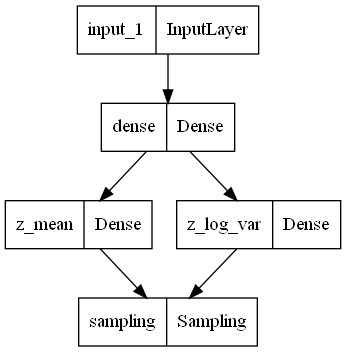

In [13]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(encoder, to_file='encoder.png')

## Build the decoder


In [14]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50,  activation=ReLu)(latent_inputs)
decoder_outputs = layers.Dense(618 * 3, activation="linear")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1854)              94554     
                                                                 
Total params: 99,604
Trainable params: 99,604
Non-trainable params: 0
_________________________________________________________________


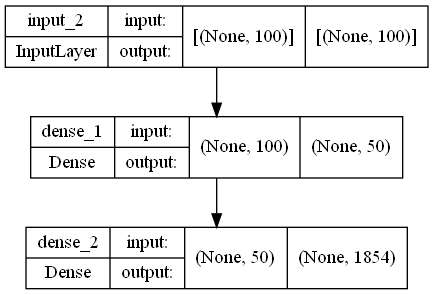

In [15]:
plot_model(decoder,  show_shapes=True, show_layer_names=True)

## Define the VAE as a Model with a custom train_step


## Train the VAE

In [16]:
vae = VAE(encoder, decoder, 1)

In [17]:
vae.compile(optimizer=keras.optimizers.Adam())

In [18]:
es = keras.callbacks.EarlyStopping(
    monitor="MSE",
    patience=4,
)

In [19]:
history = vae.fit(X_train_esc, y_train, validation_data=(X_test_esc , y_test), epochs=15, batch_size=1 )

Epoch 1/15
54/54 [==============================] - 2s 12ms/step - loss: 54.0387 - MSE: 0.0518 - kl_loss: 44.7104 - val_loss_val: 36.5911 - val_MSE_val: 0.0424 - val_kl_loss_val: 36.5487
Epoch 2/15
54/54 [==============================] - 0s 5ms/step - loss: 25.0527 - MSE: 0.0320 - kl_loss: 21.7869 - val_loss_val: 31.6173 - val_MSE_val: 0.0357 - val_kl_loss_val: 31.5816
Epoch 3/15
54/54 [==============================] - 0s 6ms/step - loss: 16.6207 - MSE: 0.0274 - kl_loss: 15.2409 - val_loss_val: 27.7791 - val_MSE_val: 0.0275 - val_kl_loss_val: 27.7516
Epoch 4/15
54/54 [==============================] - 0s 5ms/step - loss: 11.0901 - MSE: 0.0235 - kl_loss: 11.1509 - val_loss_val: 25.9185 - val_MSE_val: 0.0239 - val_kl_loss_val: 25.8946
Epoch 5/15
54/54 [==============================] - 0s 7ms/step - loss: 12.4467 - MSE: 0.0223 - kl_loss: 11.0628 - val_loss_val: 23.1830 - val_MSE_val: 0.0233 - val_kl_loss_val: 23.1596
Epoch 6/15
54/54 [==============================] - 0s 6ms/step - los

In [20]:

print('NRMSE', nrmse(vae.predict(X_test), y_test))
print('MAE', mae(vae.predict(X_test), y_test))
print('RMSE', math.sqrt(mse(vae.predict(X_test), y_test)))
print('MSE', mse(vae.predict(X_test), y_test))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x0000019A415E4670>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
NRMSE 1.0898117757488084
MAE 2.184123866366553
RMSE 0.7734931760840245
MSE 0.585135025085137


# PLOTS


In [21]:
y_pred = vae.predict(X_test_esc)

In [22]:
samp_num = 1

In [23]:
name_ds = 'UE0'

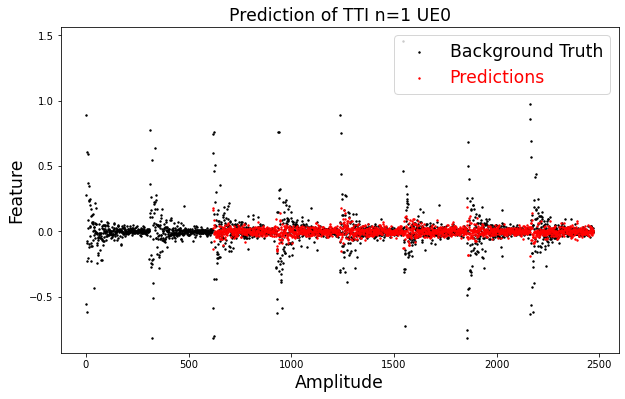

In [24]:
plot_1TTI(y_test, y_pred, X_test, samp_num, name_ds)



In [23]:
print(history.history.keys())

dict_keys(['loss', 'MSE', 'kl_loss', 'val_loss_val', 'val_MSE_val', 'val_kl_loss_val'])


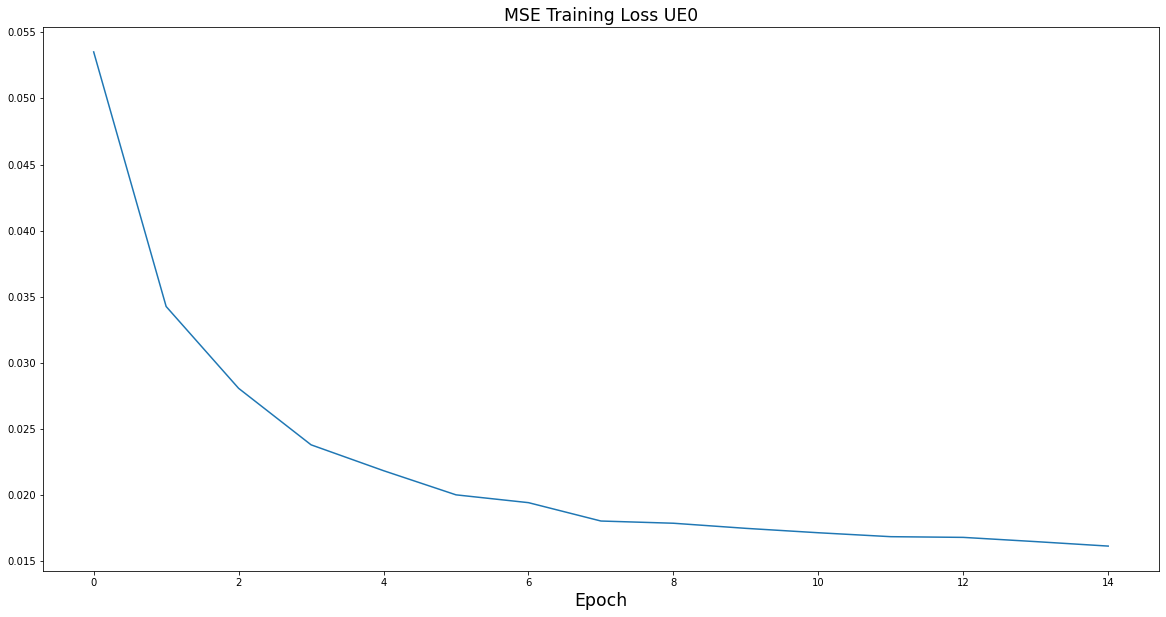

In [24]:
plot_mse_loss(history, name_ds)

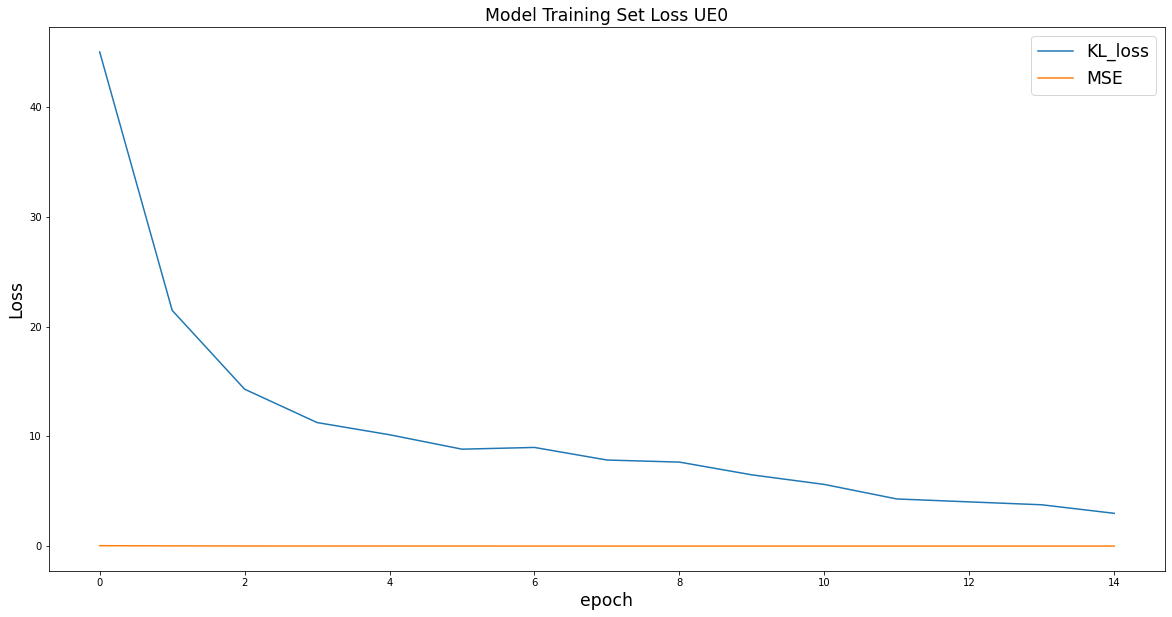

In [25]:
plot_kl_mse(history, name_ds)
    


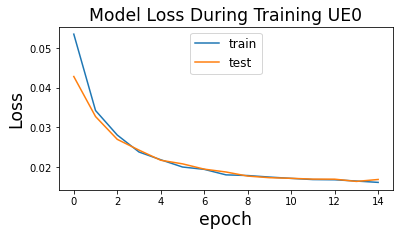

In [26]:
# summarize history for accuracy
plot_train_test(history, name_ds)


In [27]:
y_test.shape

(36, 1854)

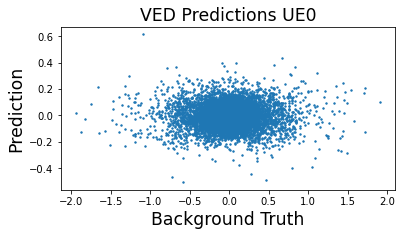

In [28]:
plot_pred_vs_true(y_pred, y_test, name_ds)

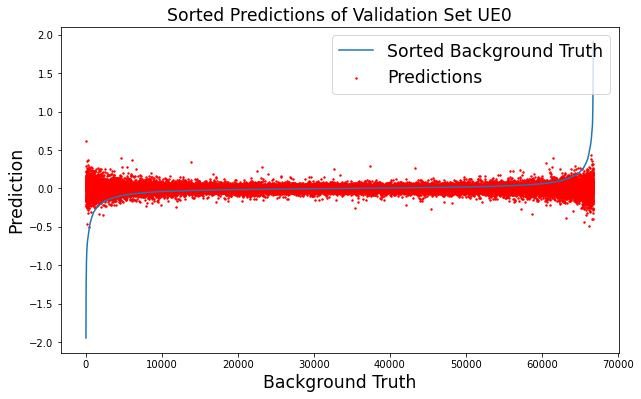

In [29]:
plot_sorted_vs_true(y_pred, y_test, name_ds)

    

# 

# Modeling

In [28]:
data = pd.read_csv("../Data/data_90TTI/data_unfold.csv", index_col=0).values

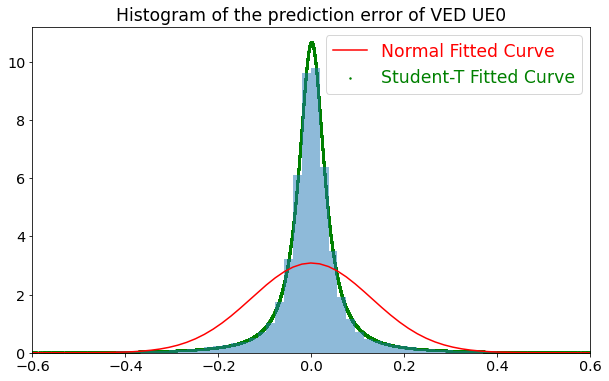

In [31]:
plot_modeling_prediction_error(data, y_test, y_pred, name_ds)

## Plots Over Time

In [29]:
mpc = 309

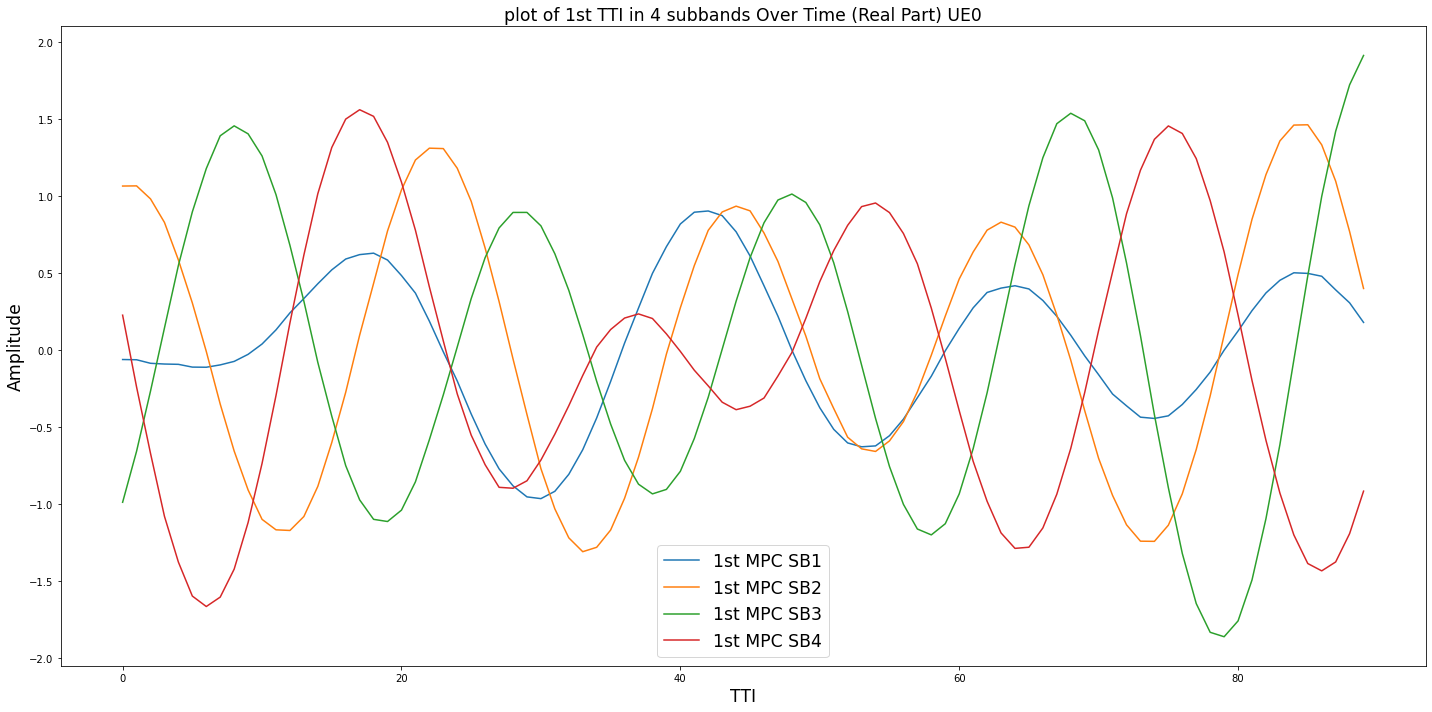

In [30]:
plot_MPC_overtime(data, mpc, name_ds, True)

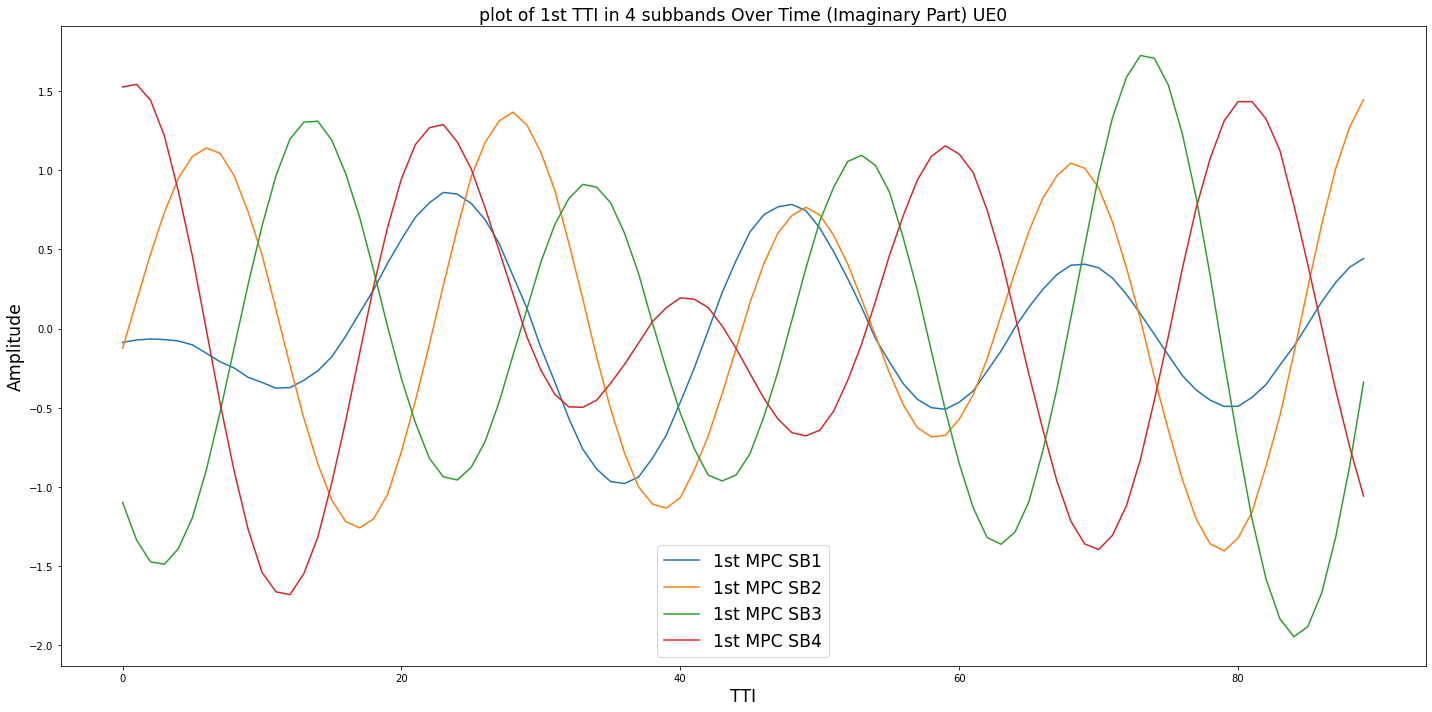

In [34]:
plot_MPC_overtime(data, mpc, name_ds, False)

# Reconstruct the validation set

In [31]:
y_pred = vae.predict(X_test)

y_pred.shape


(36, 1854)

In [33]:
reconstruct_valid = reconstruct_validation(mpc, y_pred, X_test)
reconstruct_valid.shape

(36, 2472)

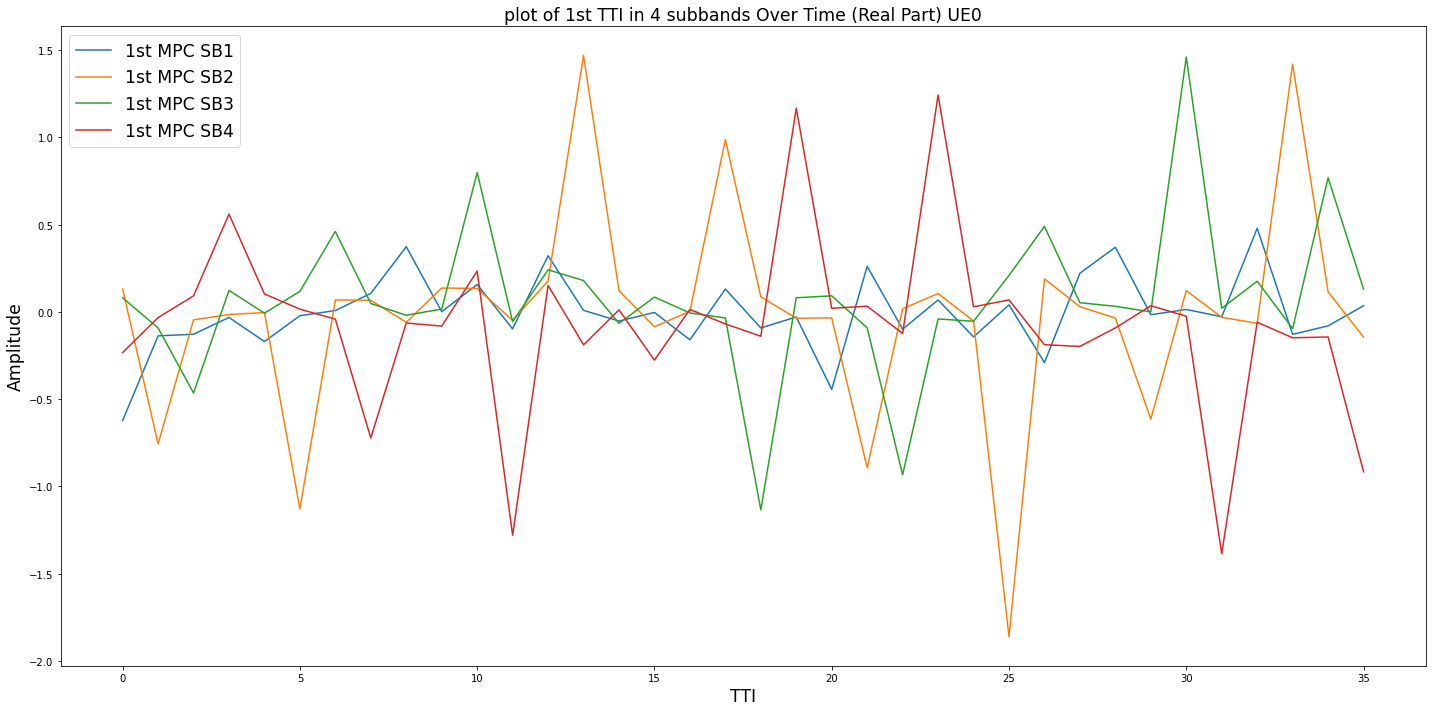

In [34]:

plot_MPC_overtime(reconstruct_valid, mpc, name_ds, True)
